In [ ]:
import glob
import os
import requests
import time
import warnings

warnings.simplefilter('ignore', FutureWarning)

from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# sns.set_style(style='whitegrid')
device_num = 0
torch.cuda.set_device(device_num)

# Полносвязные нейросети

Знакомство с полносвязными нейросетями на примере задачи классификации ирисов. 

**План:**
- Построение простейшей полносвязной нейросети;
- Реализация training loop -- её обучения;
- Замеры качества нейросети как классификатора.


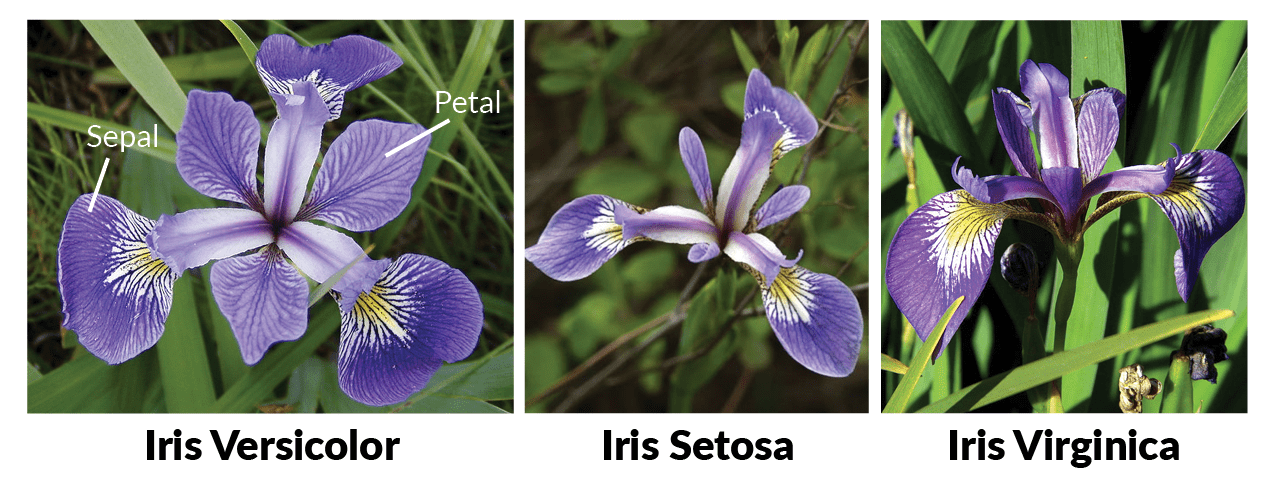

In [ ]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=179
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X.shape

(150, 4)

In [ ]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

Посмотрим на данные, используя код из занятия по `seaborn`.

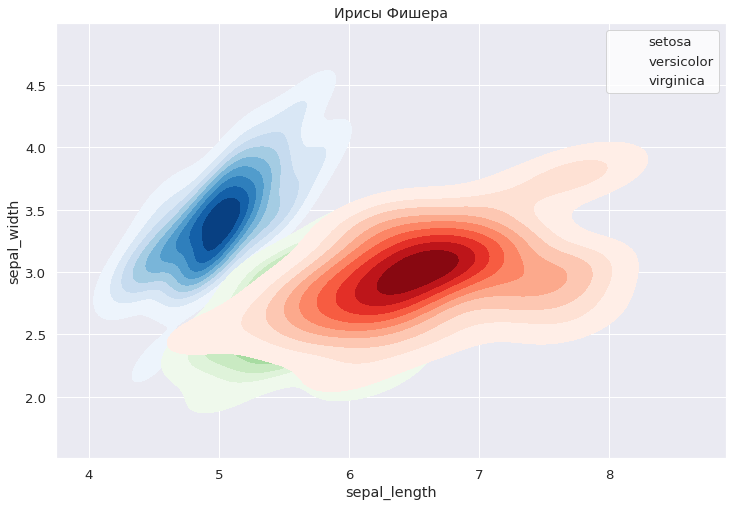

In [ ]:
sns_iris = sns.load_dataset('iris')
setosa = sns_iris[y == 0]
versicolor = sns_iris[y == 1]
virginica = sns_iris[y == 2]

plt.figure(figsize=(12, 8))
with sns.axes_style("darkgrid"):
    ax = sns.kdeplot(
        setosa.sepal_length, 
        setosa.sepal_width, 
        label="setosa", 
        cmap='Blues',
        fill=True
    )
    ax = sns.kdeplot(
        versicolor.sepal_length, 
        versicolor.sepal_width, 
        label="versicolor", 
        cmap='Greens',
        fill=True
    )
    ax = sns.kdeplot(
        virginica.sepal_length, virginica.sepal_width, 
        label="virginica", 
        cmap='Reds',
        fill=True
    )
    ax.set_title("Ирисы Фишера");
    ax.legend().get_frame().set_facecolor("white");

Реализуем простейшую полносвязную архитектуру -- **перцептрон с одним скрытым слоем**. В качестве функций активации между внутренними слоями будем использовать ReLU -- эта функция практически не ухудшает эффективность алгоритма распространения ошибки, но при этом привносит достаточную нелинейность, чтобы быть полезной.

---

Любая нейросетевая архитектура на PyTorch должна быть наследником класса nn.Module, в котором реализованы заглушки методов `forward` -- пропускания данных через нейросеть -- и `backward` -- вычисления градиентов. 

Само составление архитектуры нейросети можно воспринимать как конструктор: вы собираете её из набора блоков, которые "сшиваются" вместе при построении вычислительного графа, по которому PyTorch понимает, как вычислять градиенты методом автоматического дифференцирования. 

Интересно, что в PyTorch этот граф динамический: он сбрасывается после каждого вычисления градиентов, потому структуру сети можно изменять в процессе обучения. В частности, такой подход позволил NVIdia впервые сгенерировать реалистичные человеческие лица в высоком разрешении.

In [ ]:
class IrisPerceptron(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, hidden_dim_2: int):
        super().__init__()
        self.n_classes = 3
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, self.n_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        return self.net(x)

In [ ]:
device = f"cuda:{device_num}" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
def test(hd_1, hd_2, learn):
  global X_train, y_train, X_test, y_test
  model = IrisPerceptron(input_dim=X_train.shape[1], 
    hidden_dim=hd_1, hidden_dim_2 = hd_2
  ).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learn)
  criterion = nn.CrossEntropyLoss()
  EPOCHS  = 100

  X_train = torch.tensor(X_train, dtype=torch.float).to(device)
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
  X_test = torch.tensor(X_test, dtype=torch.float).to(device)
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)

  train_loss_list = np.zeros((EPOCHS,))
  test_loss_list = np.zeros((EPOCHS,))
  train_accuracy_list = np.zeros((EPOCHS,))
  test_accuracy_list = np.zeros((EPOCHS,))

  for epoch in tqdm(range(EPOCHS)):
      model.train()
      y_pred = model(X_train)
      loss = criterion(y_pred, y_train)
      train_loss_list[epoch] = loss.item()
      correct = (torch.argmax(y_pred, dim=1) == y_train).type(torch.float)
      train_accuracy_list[epoch] = correct.mean().item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      with torch.no_grad():
          model.eval()
          y_pred = model(X_test)
          loss = criterion(y_pred, y_test)
          test_loss_list[epoch] = loss.item()
          correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.float)
          test_accuracy_list[epoch] = correct.mean().item()

  model.eval()
  fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

  ax1.plot(train_accuracy_list, label = 'train')
  ax1.plot(test_accuracy_list, label = 'test')
  ax1.set_ylabel("accuracy")
  ax1.legend()
  ax2.plot(train_loss_list, label = 'train')
  ax2.plot(test_loss_list, label = 'test')
  ax2.set_ylabel("loss")
  ax2.set_xlabel("epochs")
  ax2.legend()
  plt.show();
  with torch.no_grad():
    y_pred = np.argmax(model(X_test).detach().cpu().numpy(), axis=1)

  print(
    classification_report(
        y_test.detach().cpu().numpy(), 
        y_pred
    )
  )
  #return loss_list, accuracy_list

<ipython-input-109-b8063fe78b81>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
<ipython-input-109-b8063fe78b81>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:13: UserWarning: To copy construct from a tensor, it is recommended to use sour

  0%|          | 0/100 [00:00<?, ?it/s]

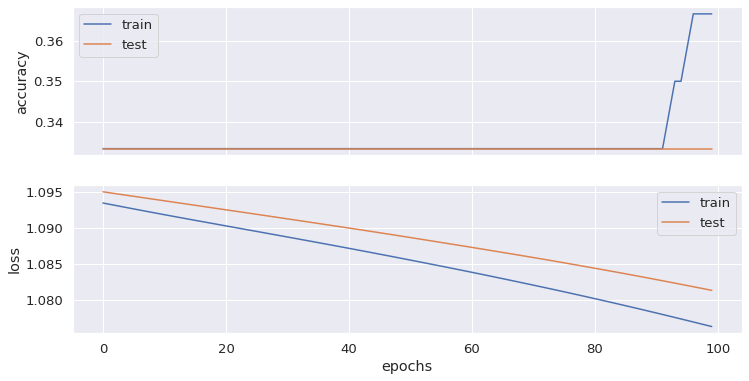

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.33      1.00      0.50        10
           2       0.00      0.00      0.00        10

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
test(30,16, 0.0001)

<ipython-input-109-b8063fe78b81>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
<ipython-input-109-b8063fe78b81>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:13: UserWarning: To copy construct from a tensor, it is recommended to use sour

  0%|          | 0/100 [00:00<?, ?it/s]

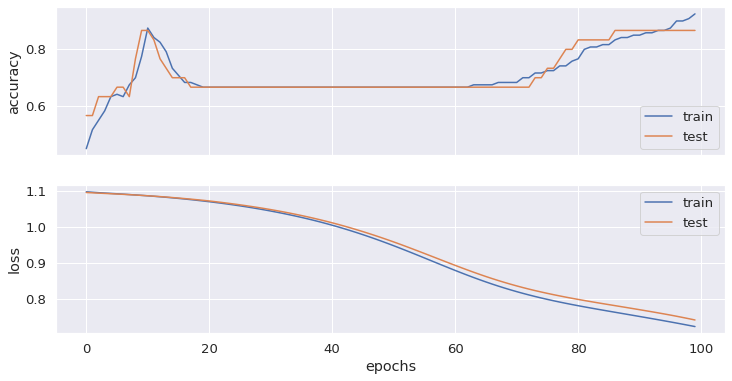

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.60      0.75        10
           2       0.71      1.00      0.83        10

    accuracy                           0.87        30
   macro avg       0.90      0.87      0.86        30
weighted avg       0.90      0.87      0.86        30



In [ ]:
test(30,16, 0.001)

<ipython-input-109-b8063fe78b81>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
<ipython-input-109-b8063fe78b81>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:13: UserWarning: To copy construct from a tensor, it is recommended to use sour

  0%|          | 0/100 [00:00<?, ?it/s]

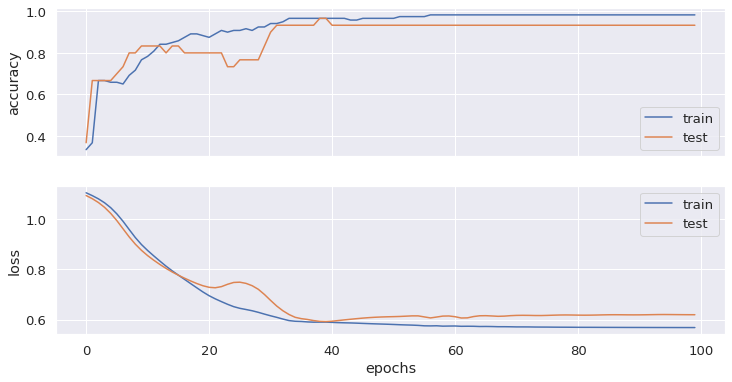

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [ ]:
test(30,16, 0.01)

<ipython-input-109-b8063fe78b81>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
<ipython-input-109-b8063fe78b81>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:13: UserWarning: To copy construct from a tensor, it is recommended to use sour

  0%|          | 0/100 [00:00<?, ?it/s]

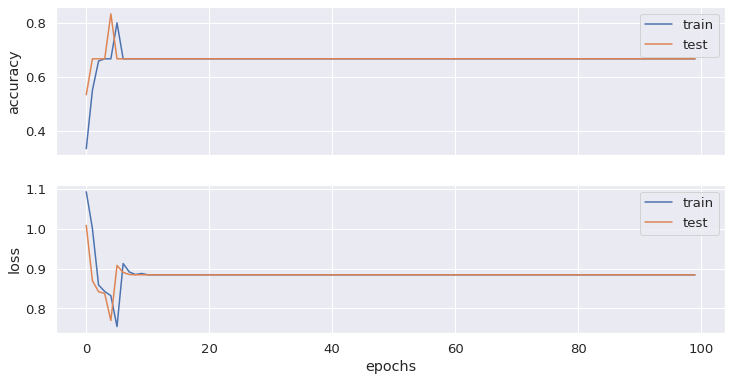

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.50      1.00      0.67        10
           2       0.00      0.00      0.00        10

    accuracy                           0.67        30
   macro avg       0.50      0.67      0.56        30
weighted avg       0.50      0.67      0.56        30



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
test(30,16, 0.1)

Чем больше learning rate в Adam, тем быстрее обучается сеть. Быстрее всего модель сходится при шаге 0.1

Вариьирую скрытые слои

<ipython-input-109-b8063fe78b81>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
<ipython-input-109-b8063fe78b81>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:13: UserWarning: To copy construct from a tensor, it is recommended to use sour

  0%|          | 0/100 [00:00<?, ?it/s]

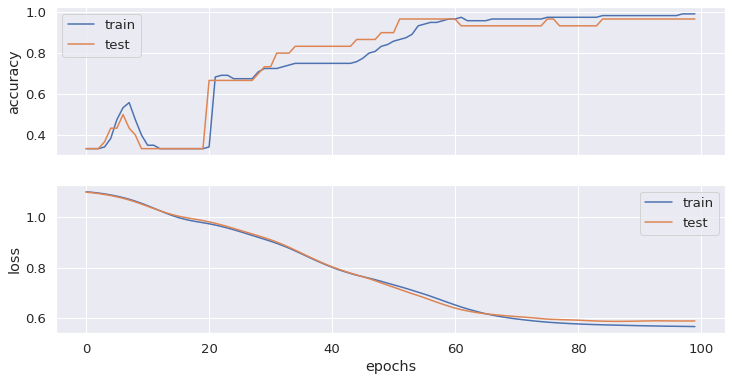

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [ ]:
test(10,6, 0.01)

<ipython-input-109-b8063fe78b81>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
<ipython-input-109-b8063fe78b81>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:13: UserWarning: To copy construct from a tensor, it is recommended to use sour

  0%|          | 0/100 [00:00<?, ?it/s]

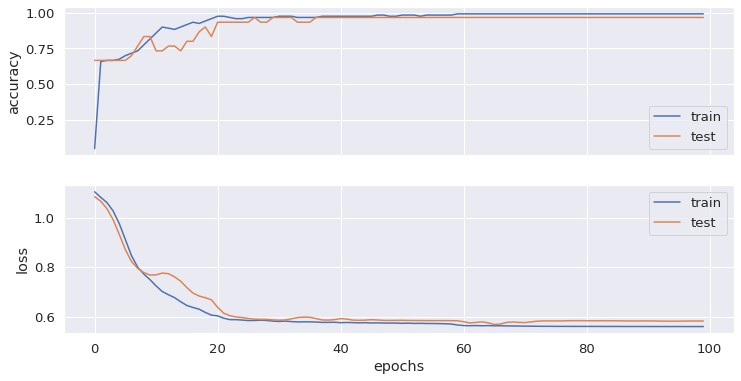

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [ ]:
test(60,32, 0.01)

<ipython-input-109-b8063fe78b81>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
<ipython-input-109-b8063fe78b81>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:13: UserWarning: To copy construct from a tensor, it is recommended to use sour

  0%|          | 0/100 [00:00<?, ?it/s]

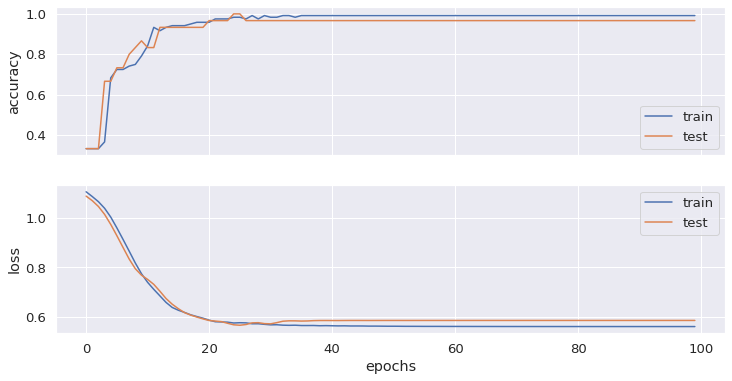

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [ ]:
test(32,60, 0.01)

<ipython-input-109-b8063fe78b81>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
<ipython-input-109-b8063fe78b81>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:13: UserWarning: To copy construct from a tensor, it is recommended to use sour

  0%|          | 0/100 [00:00<?, ?it/s]

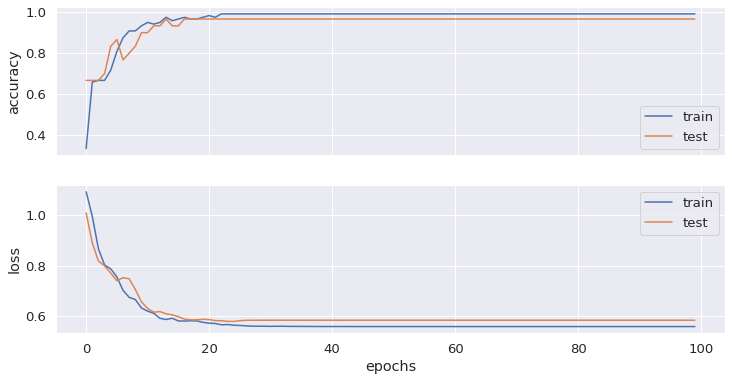

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [ ]:
test(100,100, 0.01)

<ipython-input-109-b8063fe78b81>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
<ipython-input-109-b8063fe78b81>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:13: UserWarning: To copy construct from a tensor, it is recommended to use sour

  0%|          | 0/100 [00:00<?, ?it/s]

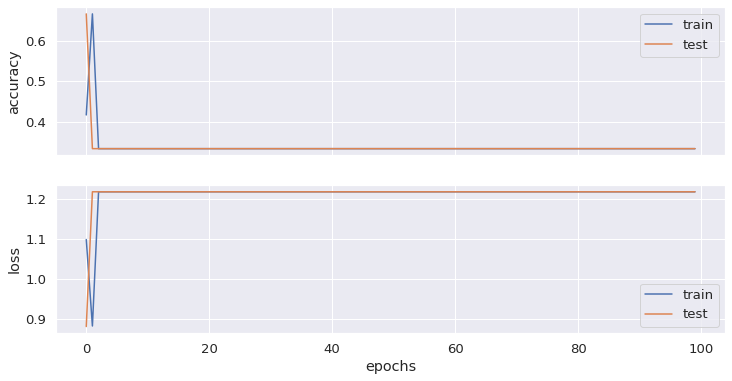

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
test(100,100, 0.1)

<ipython-input-109-b8063fe78b81>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
<ipython-input-109-b8063fe78b81>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:13: UserWarning: To copy construct from a tensor, it is recommended to use sour

  0%|          | 0/100 [00:00<?, ?it/s]

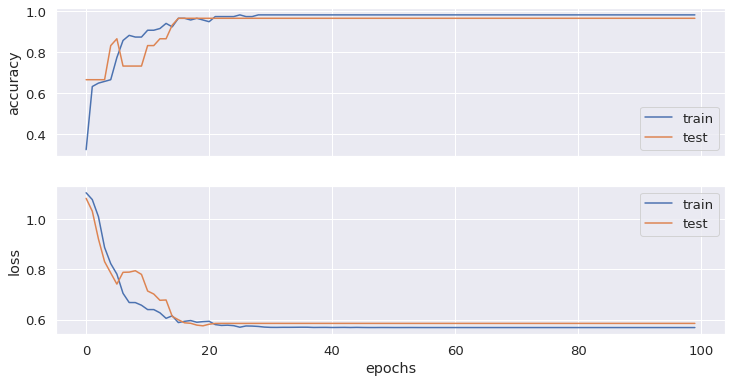

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [ ]:
test(10,12, 0.1)

<ipython-input-109-b8063fe78b81>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
<ipython-input-109-b8063fe78b81>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float).to(device)
<ipython-input-109-b8063fe78b81>:13: UserWarning: To copy construct from a tensor, it is recommended to use sour

  0%|          | 0/100 [00:00<?, ?it/s]

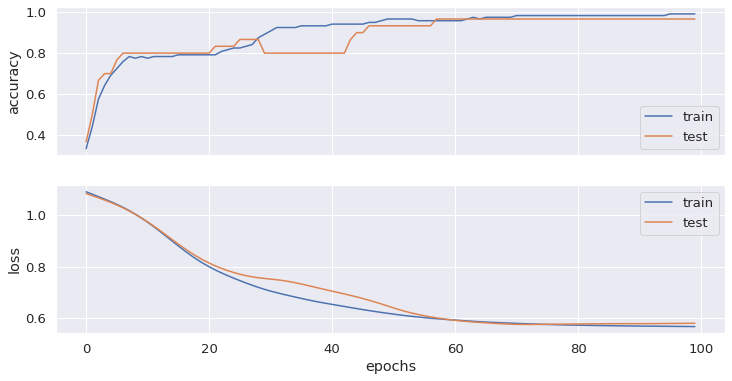

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [ ]:
test(100,100, 0.001)

Лучший accuracy и loss получились при hidden_dim = 100, hidden_dim_2 = 100, lr = 0.01)

In [ ]:
model = IrisPerceptron(input_dim=X_train.shape[1], 
  hidden_dim=100, hidden_dim_2 = 100
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
EPOCHS  = 100
X_train = torch.tensor(X_train, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)
train_loss_list = np.zeros((EPOCHS,))
test_loss_list = np.zeros((EPOCHS,))
train_accuracy_list = np.zeros((EPOCHS,))
test_accuracy_list = np.zeros((EPOCHS,))
for epoch in tqdm(range(EPOCHS)):
    model.train()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    train_loss_list[epoch] = loss.item()
    correct = (torch.argmax(y_pred, dim=1) == y_train).type(torch.float)
    train_accuracy_list[epoch] = correct.mean().item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        model.eval()
        y_pred = model(X_test)
        loss = criterion(y_pred, y_test)
        test_loss_list[epoch] = loss.item()
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.float)
        test_accuracy_list[epoch] = correct.mean().item()
model.eval()

  0%|          | 0/100 [00:00<?, ?it/s]

IrisPerceptron(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=3, bias=True)
    (7): Softmax(dim=1)
  )
)

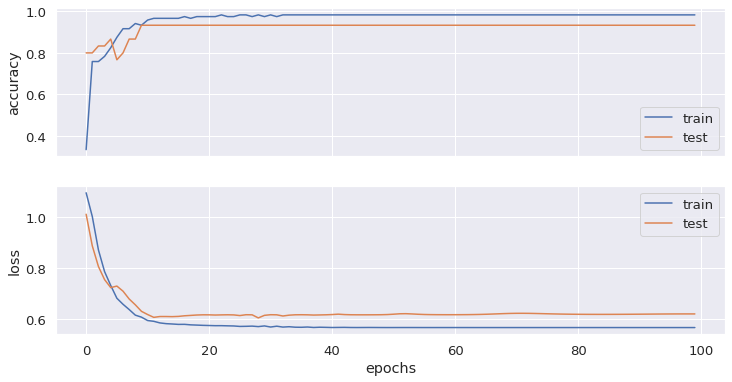

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
ax1.plot(train_accuracy_list, label = 'train')
ax1.plot(test_accuracy_list, label = 'test')
ax1.set_ylabel("accuracy")
ax1.legend()
ax2.plot(train_loss_list, label = 'train')
ax2.plot(test_loss_list, label = 'test')
ax2.set_ylabel("loss")
ax2.set_xlabel("epochs")
ax2.legend()
plt.show();

In [ ]:
with torch.no_grad():
    y_pred = np.argmax(model(X_test).detach().cpu().numpy(), axis=1)

print(
    classification_report(
        y_test.detach().cpu().numpy(), 
        y_pred
    )
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

